In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [122]:
df = pd.read_csv('drive/My Drive/WAF/Building_Permits.csv')

<ipython-input-122-57a5f811be4c>:1: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('drive/My Drive/WAF/Building_Permits.csv')


In [123]:
df.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


In [124]:
df.dtypes

,0
Permit Number,object
Permit Type,int64
Permit Type Definition,object
Permit Creation Date,object
Block,object
Lot,object
Street Number,int64
Street Number Suffix,object
Street Name,object
Street Suffix,object


Converting 'Current Status' to 1/0

In [125]:
df['Current Status'].unique()
# Approved applications = 'approved', 'complete', 'reinstated', 'issued'

array(['expired', 'issued', 'withdrawn', 'complete', 'filed', 'approved',
       'reinstated', 'cancelled', 'appeal', 'suspend', 'revoked',
       'plancheck', 'disapproved', 'incomplete'], dtype=object)

In [126]:
approved_states = ['issued', 'complete', 'approved', 'reinstated']
df['Current Status'] = df['Current Status'].isin(approved_states).astype(int)

In [127]:
df['Current Status'].mean()

0.9146907993966817

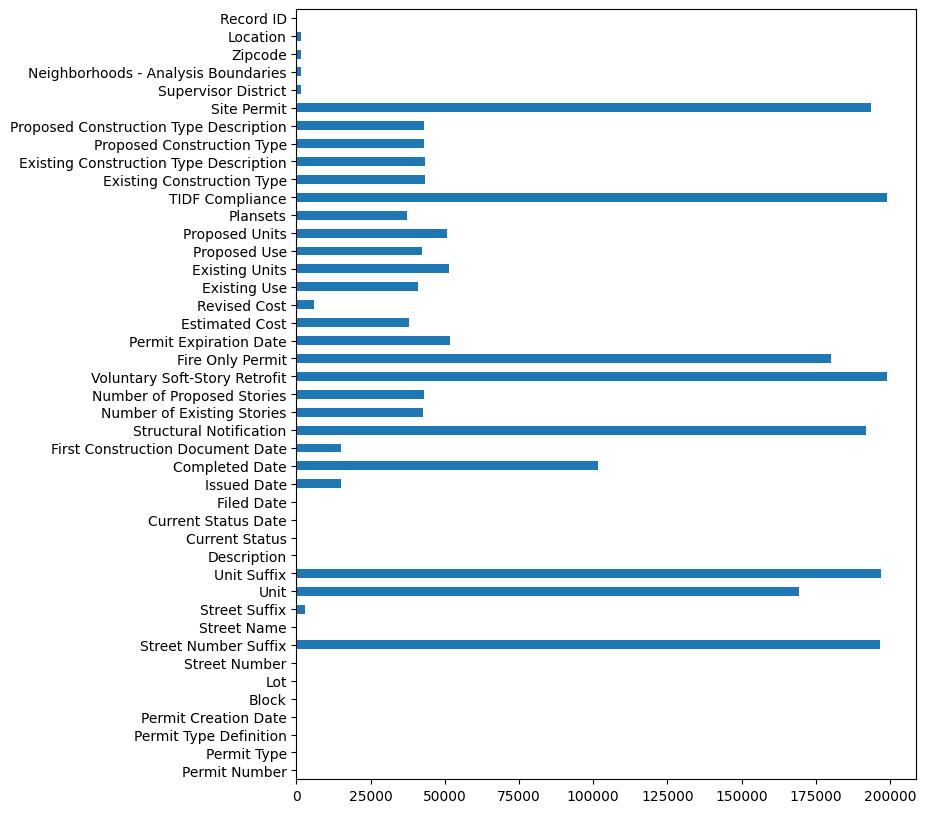

In [128]:
nans = df.isna().sum()
plt.figure(figsize = (8, 10))
nans.plot(kind='barh')
plt.show()

Basically no info in Unit/Street Number Suffix, Site Permit since they are basically all NaN (no info)

Drop Completed Date since that kind of defeats the point of the task

Drop Descriptions

In [129]:
df = df.drop(['Unit Suffix', 'Street Number Suffix', 'Site Permit', 'Unit', 'Completed Date'], axis = 1)
df = df.drop(['Proposed Construction Type Description', 'Existing Construction Type Description', 'Description', 'Record ID', 'Permit Type Definition'], axis = 1)

In [130]:
numerical = df.select_dtypes(include=['int64', 'float64'])
numerical.head()

,Permit Type,Street Number,Current Status,Number of Existing Stories,Number of Proposed Stories,Estimated Cost,Revised Cost,Existing Units,Proposed Units,Plansets,Existing Construction Type,Proposed Construction Type,Supervisor District,Zipcode
0,4,140,0,6.0,NaN,4000.0,4000.0,143.0,NaN,2.0,3.0,NaN,3.0,94102.0
1,4,440,1,7.0,NaN,1.0,500.0,NaN,NaN,2.0,3.0,NaN,3.0,94102.0
2,3,1647,0,6.0,6.0,20000.0,NaN,39.0,39.0,2.0,1.0,1.0,3.0,94109.0
3,8,1230,1,2.0,2.0,2000.0,2000.0,1.0,1.0,2.0,5.0,5.0,3.0,94109.0
4,6,950,1,3.0,NaN,100000.0,100000.0,NaN,NaN,2.0,3.0,NaN,6.0,94102.0


<Axes: >

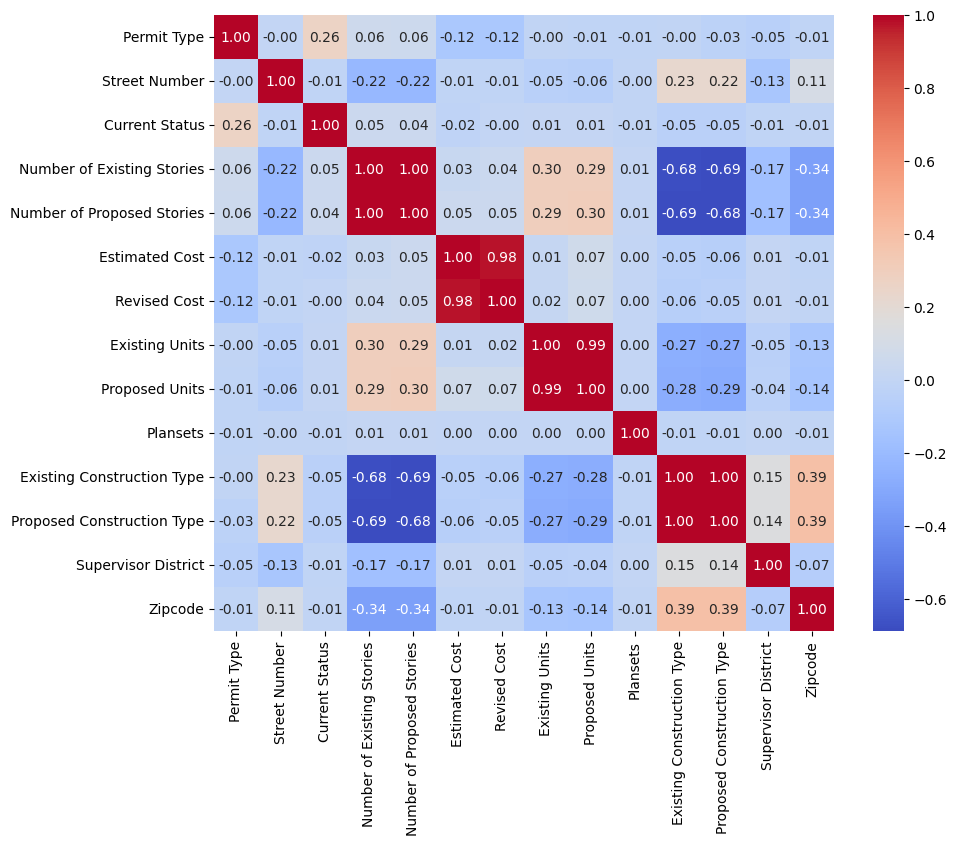

In [131]:
plt.figure(figsize = (10, 8))
sns.heatmap(numerical.corr(), annot=True, cmap='coolwarm', fmt='.2f')

Drop highly collinear columns, drop one with more NaNs

In [132]:
df = df.drop(['Number of Existing Stories', 'Estimated Cost', 'Existing Units', 'Existing Construction Type'], axis = 1)

# Filling Missing Values
- Converting Y/NaN to 1/0
- Catagorical values that are "missing info" get filled with a different value
  - Otherwise backfill
- Inundating numerical values with mean

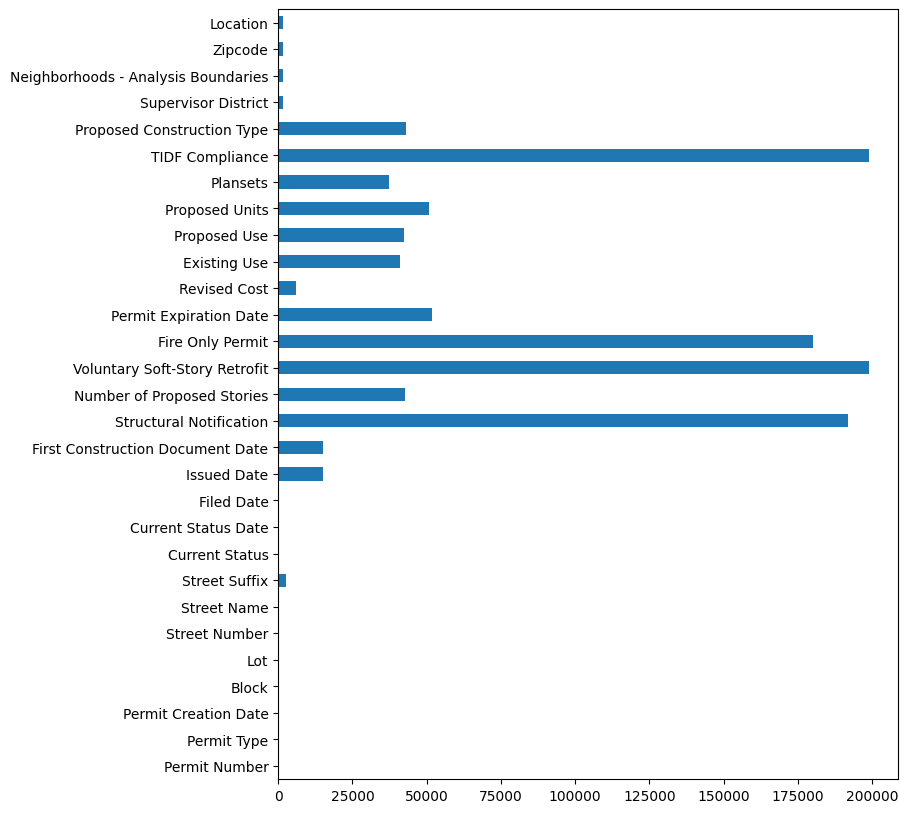

In [ ]:
nans = df.isna().sum()
plt.figure(figsize = (8, 10))
nans.plot(kind='barh')
plt.show()

In [133]:
df['Plansets'].unique()

array([2.e+00, 0.e+00,    nan, 6.e+00, 4.e+00, 3.e+00, 2.e+01, 9.e+03,
       1.e+00])

In [134]:
df['Structural Notification'] = (df['Structural Notification'].notna()).astype(int)
df['Fire Only Permit'] = (df['Fire Only Permit'].notna()).astype(int)
df['Voluntary Soft-Story Retrofit'] = (df['Voluntary Soft-Story Retrofit'].notna()).astype(int)

# Has a 'P', assuming this means partial
df['TIDF Compliance'] = df['TIDF Compliance'].map({np.NaN : 0, 'P' : 1, 'Y' : 2})

In [135]:
df['Proposed Units'] = df['Proposed Units'].fillna(df['Proposed Units'].mean())
df['Number of Proposed Stories'] = df['Number of Proposed Stories'].fillna(df['Number of Proposed Stories'].mean())

In [136]:
df['Proposed Construction Type'] = df['Proposed Construction Type'].fillna(0)
df['Plansets'] = df['Plansets'].fillna(5) # fill with some random integer, this is catagorical
df['Street Suffix'] = df['Street Suffix'].fillna('')

In [137]:
df['Proposed Units'] = df['Proposed Units'].bfill()
df['Permit Expiration Date'] = df['Permit Expiration Date'].bfill()
df['First Construction Document Date'] = df['First Construction Document Date'].bfill()
df['Issued Date'] = df['Issued Date'].bfill()

Changing Dates to integers

In [138]:
df['Permit Creation Date'].min()

'01/02/2013'

In [37]:
date_cols = ['Permit Creation Date', 'Current Status Date', 'Filed Date', 'Issued Date', 'First Construction Document Date', 'Permit Expiration Date']
reference_date = pd.Timestamp('2010-01-01')
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = (df[col] - reference_date).dt.days

In [ ]:
df.head()

,Permit Number,Permit Type,Permit Creation Date,Block,Lot,Street Number,Street Name,Street Suffix,Current Status,Current Status Date,...,Existing Use,Proposed Use,Proposed Units,Plansets,TIDF Compliance,Proposed Construction Type,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location
0,201505065519,4,1951,0326,023,140,Ellis,St,0,2911,...,tourist hotel/motel,NaN,16.51095,2.0,0,0.0,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)"
1,201604195146,4,2300,0306,007,440,Geary,St,1,2771,...,tourist hotel/motel,NaN,16.51095,2.0,0,0.0,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)"
2,201605278609,3,2338,0595,203,1647,Pacific,Av,0,2825,...,retail sales,retail sales,39.00000,2.0,0,1.0,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)"
3,201611072166,8,2502,0156,011,1230,Pacific,Av,1,2761,...,1 family dwelling,1 family dwelling,1.00000,2.0,0,5.0,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)"
4,201611283529,6,2523,0342,001,950,Market,St,1,2891,...,retail sales,NaN,16.51095,2.0,0,0.0,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)"


So few rows with no zipcode/location/district/neighborhood/revised cost, just drop NaNs

In [38]:
df = df.dropna(subset = ['Revised Cost', 'Location', 'Zipcode', 'Neighborhoods - Analysis Boundaries', 'Supervisor District'])

# Feature Engineering

Indicator for if existing/proposed use are different

In [39]:
df['Existing Use'] = df['Existing Use'].fillna('')
df['Proposed Use'] = df['Proposed Use'].fillna('')

df['Use Changed'] = 1 - (df['Proposed Use'] == df['Existing Use']).astype(int) # Looks weird but this is so ____ -> NaN gets marked as no change

Converting Location into seperate Longitude/Latitude

In [24]:
df['Location']

,Location
0,0
1,1
2,2
3,3
4,4
...,...
198895,-1
198896,-1
198897,-1
198898,-1


In [41]:
def get_lat(string):
    string = string[1:-1]
    split = string.split(', ')
    return float(split[0])

def get_long(string):
    string = string[1:-1]
    split = string.split(', ')
    return float(split[1])

df['Latitude'] = df['Location'].map(get_lat)
df['Longitude'] = df['Location'].map(get_long)

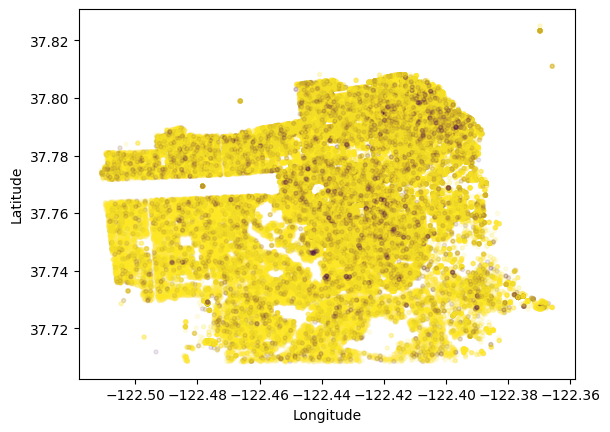

In [42]:
plt.scatter(df['Longitude'], df['Latitude'], c = df['Current Status'], s = 8, alpha = 0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Converting int/float catagorical features into objects

In [43]:
df['Zipcode'] = df['Zipcode'].astype('O')
df['Permit Type'] = df['Permit Type'].astype('O')
df['Street Number'] =df['Street Number'].astype('O')
df['Plansets'] = df['Plansets'].astype('O')
df['Supervisor District'] = df['Supervisor District'].astype('O')

# Mutual Info Classification
Trying to remove some features

In [22]:
df.dtypes

,0
Permit Number,object
Permit Type,object
Permit Creation Date,int64
Block,object
Lot,object
Street Number,object
Street Name,object
Street Suffix,object
Current Status,int64
Current Status Date,int64


In [44]:
 # factorize
for col in df.select_dtypes(['object']):
    df[col], _ = df[col].factorize()

X = df.drop('Current Status', axis = 1)
y = df['Current Status']

discrete_features = [pd.api.types.is_number(col) for col in X.dtypes] # all cols are either int, float, or object
mic_scores = mutual_info_classif(X, y, discrete_features=discrete_features)


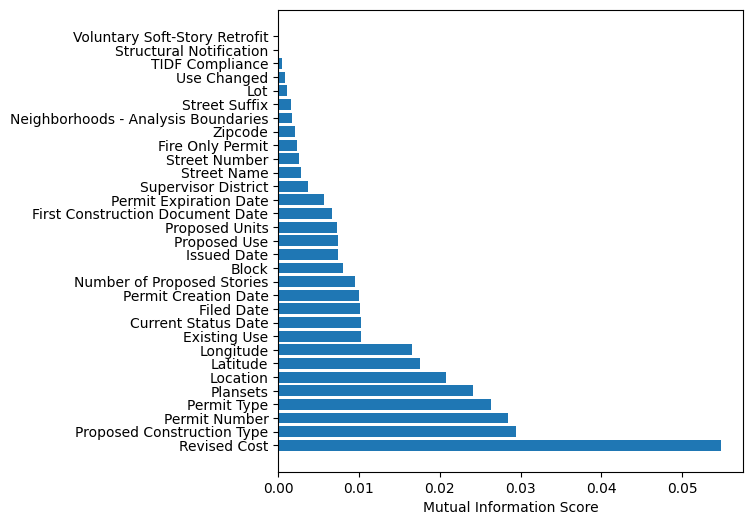

In [45]:
mic_scores = pd.Series(mic_scores, name="MIC", index=X.columns)
mic_scores = mic_scores.sort_values(ascending=False)

plt.figure(figsize = (6, 6))
plt.barh(np.arange(len(mic_scores)), mic_scores)
plt.yticks(np.arange(len(mic_scores)), mic_scores.index)
plt.xlabel('Mutual Information Score')
plt.show()

In [46]:
df_selected = df[['Current Status', 'Revised Cost', 'Proposed Construction Type', 'Permit Number', 'Permit Type', 'Plansets', 'Latitude', 'Longitude', 'Current Status Date', 'Existing Use', 'Permit Creation Date', 'Filed Date', 'Number of Proposed Stories']]

#PCA on numerical features

In [96]:
X_num = df_selected.select_dtypes(include=['int64', 'float64']).drop('Current Status', axis = 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

pca = PCA(n_components = 4)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4'])


In [97]:
pca.explained_variance_ratio_

array([0.321588  , 0.17182504, 0.12240671, 0.09244531])

In [98]:
pure_features = pd.DataFrame(columns = X_num.columns)

for i in range (len(X_num.columns)):
    canonical_vector = np.zeros(len(X_num.columns))
    canonical_vector[i] = 1
    pure_features.loc[len(pure_features)] = canonical_vector

In [99]:
feature_vectors_pca = pca.fit_transform(scaler.fit_transform(pure_features))

def get_angle(u, v):
    dot_prod = np.dot(u,v)

    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)

    radians = np.arccos(dot_prod / (norm_u * norm_v))
    degrees = np.degrees(radians)

    return degrees

angles = np.zeros(shape = feature_vectors_pca.shape)
for i in range(len(feature_vectors_pca)):
    angles[i, 0] = get_angle(feature_vectors_pca[i], np.array([1, 0, 0, 0]))
    angles[i, 1] = get_angle(feature_vectors_pca[i], np.array([0, 1, 0, 0]))
    angles[i, 2] = get_angle(feature_vectors_pca[i], np.array([0, 0, 1, 0]))
    angles[i, 3] = get_angle(feature_vectors_pca[i], np.array([0, 0, 0, 1]))

In [102]:
print("PC1" + " " + str(pure_features.columns[3])) # +
print("PC2" + " " + str(pure_features.columns[7])) # -
print("PC3" + " " + str(pure_features.columns[0])) # +
print("PC4" + " " + str(pure_features.columns[8])) # +

PC1 Permit Type
PC2 Current Status Date
PC3 Revised Cost
PC4 Existing Use


<Axes: >

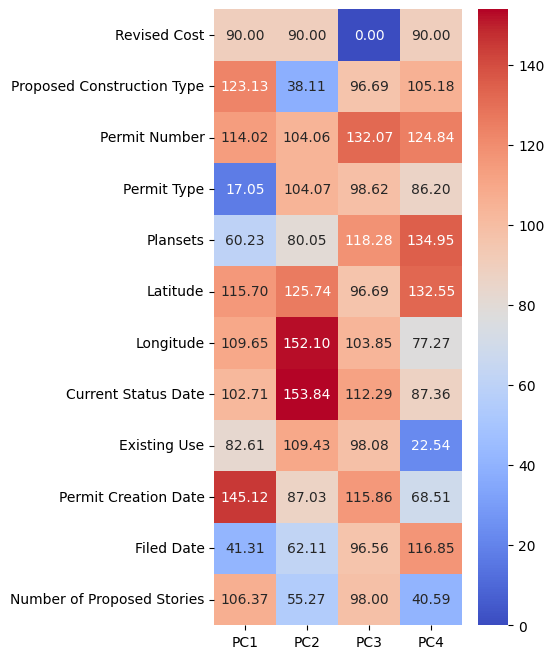

In [118]:
angles = pd.DataFrame(angles)

plt.figure(figsize = (4, 8))
sns.heatmap(angles, annot=True, cmap='coolwarm', fmt='.2f', xticklabels = ['PC1', 'PC2', 'PC3', 'PC4'], yticklabels = X_selected.columns)

<Axes: >

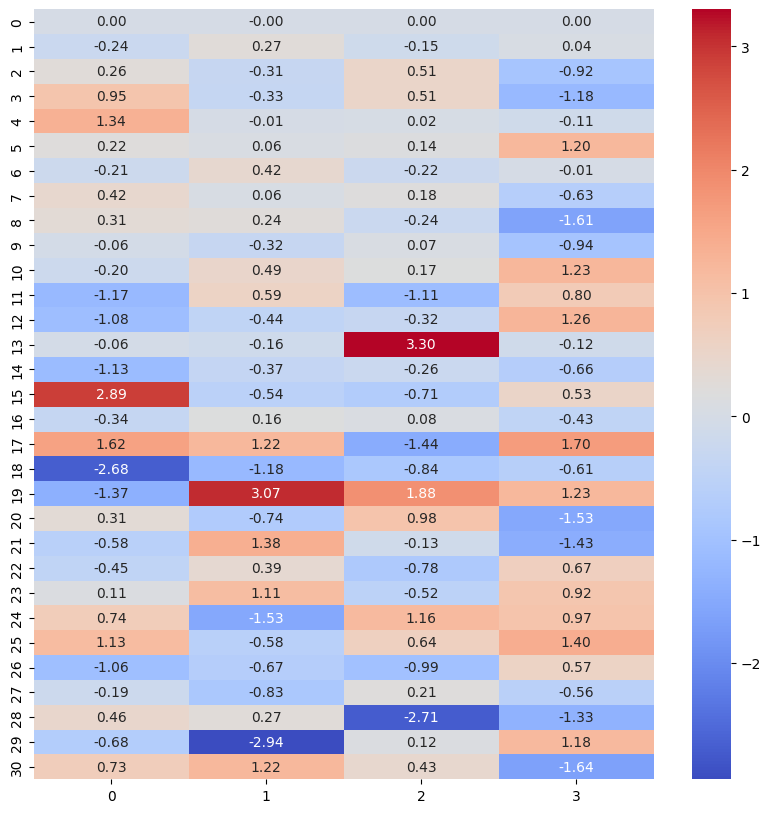

In [ ]:
plt.figure(figsize = (10, 10))
sns.heatmap(feature_vectors_pca, annot=True, cmap='coolwarm', fmt='.2f')

# Classification Models

In [47]:
X_selected = df_selected.drop('Current Status', axis = 1)
y = df_selected['Current Status']

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3)

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

log_preds = log_reg.predict(X_test)
print(classification_report(y_test, log_preds))

              precision    recall  f1-score   support

           0       0.43      0.01      0.03      3156
           1       0.95      1.00      0.97     54181

    accuracy                           0.94     57337
   macro avg       0.69      0.51      0.50     57337
weighted avg       0.92      0.94      0.92     57337



In [ ]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.97      0.60      0.74      3156
           1       0.98      1.00      0.99     54181

    accuracy                           0.98     57337
   macro avg       0.97      0.80      0.86     57337
weighted avg       0.98      0.98      0.97     57337



Balancing since mostly approved

In [48]:
df_not_approved = df_selected[df_selected['Current Status'] == 0]
df_approved = df_selected[df_selected['Current Status'] == 1]

df_downsampled = resample(df_approved, replace=False, n_samples=len(df_not_approved))
df_balanced = pd.concat([df_not_approved, df_downsampled])

In [49]:
import gc
del df_not_approved, df_approved, df_downsampled
gc.collect()

10721

In [50]:
X_balanced = df_balanced.drop('Current Status', axis = 1)
y_balanced = df_balanced['Current Status']

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3)

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_balanced, y_train_balanced)

log_preds = log_reg.predict(X_test_balanced)
print(classification_report(y_test_balanced, log_preds))

              precision    recall  f1-score   support

           0       0.57      0.60      0.58      3249
           1       0.58      0.55      0.56      3288

    accuracy                           0.57      6537
   macro avg       0.57      0.57      0.57      6537
weighted avg       0.57      0.57      0.57      6537



Random Forest (With grid searched hyperparams)

In [74]:
rf = RandomForestClassifier(n_estimators = 1000, max_depth = None, max_features = None, min_samples_split = 5)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
print(classification_report(y_test, rf_preds))

KeyboardInterrupt: 

In [55]:
rf = RandomForestClassifier(n_estimators = 1000, max_depth = None, max_features = None, min_samples_split = 5)
rf.fit(X_train_balanced, y_train_balanced)

rf_preds = rf.predict(X_test_balanced)
print(classification_report(y_test_balanced, rf_preds))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      3275
           1       0.80      0.92      0.86      3262

    accuracy                           0.85      6537
   macro avg       0.85      0.85      0.85      6537
weighted avg       0.86      0.85      0.85      6537



In [112]:
rf = RandomForestClassifier(n_estimators = 1000, max_depth = None, max_features = None, min_samples_split = 5)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.94      0.61      0.74      3233
           1       0.98      1.00      0.99     54104

    accuracy                           0.98     57337
   macro avg       0.96      0.81      0.87     57337
weighted avg       0.98      0.98      0.97     57337



In [ ]:
model = RandomForestClassifier()

param_grid = {
    'n_estimators': [500, 750, 1000, 1250, 1500],
    'max_depth': [None, 50, 100],
    'max_features' : ['sqrt', 'log2', None]

}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 2)

grid_search.fit(X_train_balanced, y_train_balanced)

best_rf_model = grid_search.best_estimator_
best_rf_params = grid_search.best_params_
best_rf_score = grid_search.best_score_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
best_rf_params

{'max_depth': None, 'max_features': None, 'n_estimators': 1000}

Tuned XGB on balanced

In [73]:
xgb_model = xgb.XGBClassifier(eta = 0.1, gamma = 0, reg_lambda = 1, max_depth = 15, min_child_weight = 1)
xgb_model.fit(X_train_balanced, y_train_balanced)

xgb_preds = xgb_model.predict(X_test_balanced)
print(classification_report(y_test_balanced, xgb_preds))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      3275
           1       0.80      0.91      0.85      3262

    accuracy                           0.84      6537
   macro avg       0.85      0.84      0.84      6537
weighted avg       0.85      0.84      0.84      6537



Tuned XGB on unbalanced

In [70]:
xgb_model = xgb.XGBClassifier(eta = 0.1, gamma = 0, reg_lambda = 1, max_depth = 15, min_child_weight = 1)
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)
print(classification_report(y_test, xgb_preds))

              precision    recall  f1-score   support

           0       0.94      0.60      0.73      3233
           1       0.98      1.00      0.99     54104

    accuracy                           0.98     57337
   macro avg       0.96      0.80      0.86     57337
weighted avg       0.97      0.98      0.97     57337



XGB Grid Search

In [62]:
model = xgb.XGBClassifier()

# Define the parameter grid
param_grid = {
    'eta': [i/10 for i in range(1,6)],
    'gamma': [i for i in range(4)],
    'max_depth': [3*i for i in range(1, 6)],
    'min_child_weight' : [i for i in range(4)],
    'lambda' : [i for i in range(4)]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 2)

grid_search.fit(X_train_balanced, y_train_balanced)

best_xgb_model = grid_search.best_estimator_
best_xgb_params = grid_search.best_params_
best_xgb_score = grid_search.best_score_

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


In [68]:
best_xgb_params

{'eta': 0.1, 'gamma': 0, 'lambda': 1, 'max_depth': 15, 'min_child_weight': 1}

In [69]:
best_xgb_score

0.838851631553213

# Trying to fit using PCA stuff

In [103]:
print("PC1" + " " + str(pure_features.columns[3])) # +
print("PC2" + " " + str(pure_features.columns[7])) # -
print("PC3" + " " + str(pure_features.columns[0])) # +
print("PC4" + " " + str(pure_features.columns[8])) # +


PC1 Permit Type
PC2 Current Status Date
PC3 Revised Cost
PC4 Existing Use


In [108]:
X_balanced_PC = X_balanced[['Permit Type', 'Current Status Date', 'Revised Cost', 'Existing Use']]
X_PC = X_selected[['Permit Type', 'Current Status Date', 'Revised Cost', 'Existing Use']]

X_train_PC_balanced, X_test_PC_balanced, y_train_PC_balanced, y_test_PC_balanced = train_test_split(X_balanced_PC, y_balanced, test_size=0.3)
X_train_PC, X_test_PC, y_train_PC, y_test_PC = train_test_split(X_PC, y, test_size=0.3)


In [110]:
xgb_model = xgb.XGBClassifier(eta = 0.1, gamma = 0, reg_lambda = 1, max_depth = 15, min_child_weight = 1)
xgb_model.fit(X_train_PC_balanced, y_train_PC_balanced)

xgb_preds = xgb_model.predict(X_test_PC_balanced)
print(classification_report(y_test_PC_balanced, xgb_preds))

              precision    recall  f1-score   support

           0       0.78      0.66      0.71      3283
           1       0.70      0.81      0.75      3254

    accuracy                           0.73      6537
   macro avg       0.74      0.74      0.73      6537
weighted avg       0.74      0.73      0.73      6537



In [111]:
xgb_model = xgb.XGBClassifier(eta = 0.1, gamma = 0, reg_lambda = 1, max_depth = 15, min_child_weight = 1)
xgb_model.fit(X_train_PC, y_train_PC)

xgb_preds = xgb_model.predict(X_test_PC)
print(classification_report(y_test_PC, xgb_preds))

              precision    recall  f1-score   support

           0       0.96      0.44      0.61      3383
           1       0.97      1.00      0.98     53954

    accuracy                           0.97     57337
   macro avg       0.96      0.72      0.79     57337
weighted avg       0.97      0.97      0.96     57337

